## 第8章 イベント・スタディ

### 8.3 決算発表のイベント・スタディを例にしたRでの実践

#### 8.3.1 イベントの特定

In [1]:
# ch08_01: 外部パッケージとデータの読み込み

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# pandasのバージョンによっては，将来の仕様変更に関する警告が発せられるため，それを非表示に
import warnings
warnings.filterwarnings("ignore")

# parse_dates引数を指定し，特定の列は日付形式にしてCSVファイルを読み込む
return_data = pd.read_csv("ch08_return_data.csv", parse_dates=['date'])
market_return_data = pd.read_csv("ch08_market_return_data.csv", parse_dates=['date'])
event_data = pd.read_csv("ch08_event_data.csv", parse_dates=['event_date'])

# 各データの冒頭を確認
display(return_data.head()) 
display(market_return_data.head())
display(event_data.head())

,firm_ID,date,R
0,1,2016-01-04,-0.012449
1,1,2016-01-05,-0.009189
2,1,2016-01-06,0.032097
3,1,2016-01-07,-0.029258
4,1,2016-01-08,-0.023952


,date,R_M
0,2016-01-04,-0.004356
1,2016-01-05,-0.006662
2,2016-01-06,0.021631
3,2016-01-07,-0.025959
4,2016-01-08,-0.013409


,firm_ID,event_date,realized_earnings,earnings_forecast,lagged_ME
0,1,2017-05-08,421.79,500.38,8285.87
1,2,2017-08-28,131.49,144.13,1551.31
2,3,2017-10-17,459.30,463.03,3154.17
3,4,2017-10-17,976.94,1298.48,19323.19
4,5,2017-02-09,706.28,779.63,9351.80


#### 8.3.2 グループ分けの方法 

In [2]:
# ch08_02: イベントIDを付与した上で予想利益サプライズを計算

# イベントIDを付与
event_data['event_ID'] = range(len(event_data))

# 予想利益サプライズを計算
event_data['forecast_innovation'] = (
    (event_data['earnings_forecast'] - event_data['realized_earnings']) 
    / event_data['lagged_ME']
)

# 日付データから年度を抽出
event_data['year'] = event_data['event_date'].dt.year

# 各年度ごとにイベントの強弱を5段階に区分
event_data['event_strength'] = event_data.groupby('year')['forecast_innovation'].transform(
    lambda x: pd.qcut(x, 5, labels=False) + 1
)
# コードch06_11に記載の通り，Rのntile()関数とPythonのqcut()関数では，
# サンプルを均等にグループ分けできない場合の処理の仕方が異なるので，
# 以下の一部のアウトプットでは，教科書のそれと微妙に異なるケースが出てくるので要注意．

# event_strengthをカテゴリ型へ変換
event_data['event_strength'] = event_data['event_strength'].astype('category')  

#### 8.3.3 相対日次の設定

In [3]:
# ch08_03: パラメータの準備

N_days = len(market_return_data)  # データに含まれる日数をカウント
N_firms = return_data['firm_ID'].nunique()  # 企業の固有数をカウント
N_events = len(event_data)  # イベント数をカウント

N1 = 100  # モデルの推定期間
N2 = 30  # イベント前の分析期間
N3 = 30  # イベント後の分析期間

In [4]:
# ch08_04: 日付IDの付与

# 各営業日に日付IDを順番に付与
market_return_data['date_ID'] = range(N_days)

# 各営業日と日付IDを紐付けるデータテーブルを作成
data_ID_table = market_return_data[['date', 'date_ID']]

# リターン・データに日付IDを付与
return_data = return_data.merge(
    data_ID_table, 
    on='date', 
    how='outer'
)

# イベント・データに日付IDを付与
event_data = event_data.merge(
    data_ID_table, 
    left_on='event_date', 
    right_on='date', 
    how='left'
)

# 不要な列を削除
event_data = event_data[['event_ID', 'date_ID', 'firm_ID', 'event_strength']]

# 後のステップで列名の重複を避けるために列名を変更
event_data.rename(columns={'date_ID': 'event_date_ID'}, inplace=True)

In [5]:
# ch08_05: 各データセットを統合して単一のデータフレームに (1)

# date列が重複するので削除
return_data = return_data.drop(columns=['date'])

# 市場ポートフォリオのリターンと結合
return_data = return_data.merge(
    market_return_data, 
    on='date_ID', 
    how='outer'
)

In [6]:
# ch08_06: 各データセットを統合して単一のデータフレームに (2)

# イベント・データとリターン・データを結合する上で骨格となるデータフレームを作成
full_sample_data = pd.DataFrame({
    'event_ID': list(range(N_events)) * (N1 + N2 + N3 + 1),
    'relative_days': list(range(-(N1 + N2), N3 + 1)) * N_events
})

# event_IDとrelative_daysによるデータのソート
full_sample_data.sort_values(by=['event_ID', 'relative_days'], inplace=True)

# インデックスをリセット
full_sample_data.reset_index(drop=True, inplace=True)

In [7]:
# ch08_07: 各データセットを統合して単一のデータフレームに (3)

# イベント・データと結合
full_sample_data = full_sample_data.merge(
    event_data, 
    on='event_ID', 
    how='outer'
)

# event_date_IDとrelative_daysからdate_IDを逆算（取引時間終了後の決算発表を仮定して1日足す）
full_sample_data['date_ID'] = (
    full_sample_data['event_date_ID'] + 
    full_sample_data['relative_days'] + 
    1
)

# リターン・データと結合
full_sample_data = full_sample_data.merge(
    return_data, 
    on=['firm_ID', 'date_ID'], 
    how='left'
)

# 不要な列を削除
full_sample_data = full_sample_data[['event_ID', 'event_strength', 'relative_days', 'R', 'R_M']]

#### 8.3.4 異常リターンの算定 

In [8]:
# ch08_08: マーケット・モデルの推定 (1)

# 推定期間のデータのみ抽出
estimation_window_data = full_sample_data[full_sample_data['relative_days'] < -N2]

# 推定結果を保存するための空のリストを準備
market_model_results = []

for i in range(N_events):

    # マーケット・モデルの推定
    lm_results = smf.ols(
        'R ~ R_M', 
        data=estimation_window_data[estimation_window_data['event_ID'] == i]
    ).fit()

    # 推定結果を整形
    tidied_lm_results = lm_results.summary2().tables[1]
    
    # 推定対象のイベントIDを保存
    tidied_lm_results.insert(0, 'event_ID', i)  

    # マーケット・モデルの推定により得られた残差の標準誤差を抽出してsigma_ARと保存
    tidied_lm_results['sigma_AR'] = lm_results.resid.std()  
    # std()では自由度の調整が行われないため，Rの結果と誤差が生じる
    # Rと同様，自由度を考慮してsigma_ARを計算する場合，以下のように書けば良い
    # df_residual = len(lm_results.resid) - (lm_results.df_model + 1)
    # tidied_lm_results['sigma_AR'] = np.sqrt(np.sum(lm_results.resid**2) / df_residual)

    # リストの一要素として推定結果を保存
    market_model_results.append(tidied_lm_results)

# pandasのconcat()関数を用いて複数のデータフレームから構成されるリストを一つのデータフレームに統合
market_model_results = pd.concat(market_model_results)

In [9]:
# ch08_09: マーケット・モデルの推定 (2)

wider_market_model_results = (
    market_model_results.reset_index()
    .pivot_table(index=['event_ID', 'sigma_AR'], columns='index', values='Coef.')
    .rename(columns={'Intercept': 'alpha', 'R_M': 'beta'})
    .reset_index()
)

# full_sample_dataに結合
full_sample_data = full_sample_data.merge(
    wider_market_model_results, 
    on='event_ID', 
    how='outer'
)

# sigma_AR を最終列に移動
full_sample_data = full_sample_data[
    [col for col in full_sample_data.columns if col != 'sigma_AR'] + ['sigma_AR']
] 

In [10]:
# ch08_10: 累積異常リターン（CAR）の計算

# イベント期間のデータを抽出
event_window_data = (
    full_sample_data[full_sample_data['relative_days'] >= -N2]
    .copy()
    .reset_index(drop=True)
)

# ノーマルリターンを計算
event_window_data['R_normal'] = (
    event_window_data['alpha'] + event_window_data['beta'] * event_window_data['R_M']  
) 

# 異常リターンを計算
event_window_data['AR'] = (
    event_window_data['R'] - event_window_data['R_normal']  
) 

# 累積異常リターン（CAR）を計算
event_window_data['CAR'] = event_window_data.groupby('event_ID')['AR'].cumsum()

#### 8.3.5 異常リターンの集計と結果の解釈 

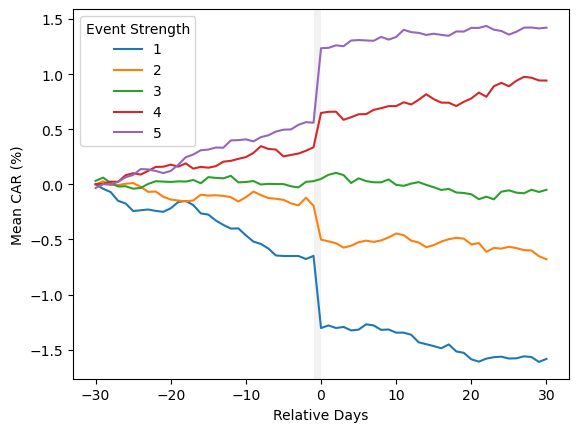

In [11]:
# ch08_11: イベントの強弱に応じて平均CARの推移を可視化

# CARの平均値を計算
mean_CAR_by_event_strength = (
    event_window_data.groupby(['relative_days', 'event_strength'])['CAR']
    .mean()
    .reset_index()
    .rename(columns={'CAR': 'mean_CAR'})  # 列名をmean_CARへと変更
)

# CARを%表示に
mean_CAR_by_event_strength['mean_CAR'] = mean_CAR_by_event_strength['mean_CAR'] * 100 

# seabornを利用して折れ線グラフを描画
sns.lineplot(
    data=mean_CAR_by_event_strength, 
    x="relative_days", 
    y="mean_CAR", 
    hue="event_strength", 
    palette='tab10'
)

# イベント発生期間を灰色で強調
plt.axvspan(-1, 0, facecolor='gray', alpha=0.1)

# x軸とy軸のラベルの設定
plt.xlabel("Relative Days")
plt.ylabel("Mean CAR (%)")
plt.legend(title='Event Strength')
plt.show()

In [12]:
# ch08_12: ARを利用した統計的検定 (1)

output_table = event_window_data[event_window_data['event_strength'] == 5].groupby('relative_days').agg(
    mean_AR=('AR', 'mean'),
    mean_CAR=('CAR', 'mean'),
    sigma_mean_AR=('sigma_AR', lambda x: (x ** 2).sum() ** 0.5 / len(x))
).reset_index()

In [13]:
# ch08_13: ARを利用した統計的検定 (2)

# SciPyライブラリから正規分布に関連する機能をインポート
from scipy.stats import norm 

# t値を計算
output_table['t_value'] = output_table['mean_AR'] / output_table['sigma_mean_AR']  

# 対応するp値を計算
output_table['p_value'] = (1 - norm.cdf(abs(output_table['t_value']))) * 2  

output_table = (
    output_table
    .assign(
        # 統計的に有意な結果を*で強調
        significance=pd.cut(
            output_table['p_value'], 
            bins=[0, 0.01, 0.05, 0.1, 1], 
            labels=['***', '**', '*', ''], 
            include_lowest=True
        ),
        # mean_ARの桁数を変更し、パーセント表示に
        mean_AR=(output_table['mean_AR'] * 100).round(5),  
        # t_valueの桁数を変更
        t_value=output_table['t_value'].round(2),  
        # p_valueの桁数を変更
        p_value=output_table['p_value'].round(2),  
        # mean_CARの桁数を変更し、パーセント表示に
        mean_CAR=(output_table['mean_CAR'] * 100).round(5)  
    )
    .filter(
        # 列の順序を変更
        ['relative_days', 'mean_AR', 't_value', 'p_value', 'significance', 'mean_CAR']
    )
)

In [14]:
# 以上のコードについて，動作確認をした実行環境の表示
# 本セルは，実行環境の確認のためであり，無視してもらっても構わない
import session_info
session_info.show(dependencies=False)